In [ ]:
pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.8 MB/s eta 0:00:00


## Tarea 1: Niveles del lenguaje

### FECHA DE ENTREGA: 16 de Febrero 2025 at 11:59pm

### Fonética

1. Si tenemos un sistema de búsqueda que recibe una palabra ortográfica y devuelve sus transcripciones fonológicas, proponga una solución para los casos en que la palabra buscada no se encuentra en el lexicón/diccionario. *¿Cómo devolver o aproximar su transcripción fonológica?*
  - Reutiliza el sistema de búsqueda visto en clase y mejoralo con esta funcionalidad

### Morfología

2. Obtenga los datos de `test` y `dev` para todas las lenguas disponibles en el Shared Task SIGMORPHON 2022 y haga lo siguiente:
    - En un plot de 4 columnas y 2 rows muestre las siguientes distribuciones (un subplot por lengua):
        - Plot 1: distribución de longitud de palabras
        - Plot 2: distribución de la cuenta de morfemas
        - Plot 3: distribución de categorias (si existe para la lengua)
    - Realice una función que imprima por cada lengua lo siguiente:
        - Total de palabras
        - La longitud de palabra promedio
        - La cuenta de morfemas promedio
        - La categoría más común
    - Con base en esta información elabore una conclusión lingüística sobre la morfología de las lenguas analizadas.
    
### EXTRA:

- Imprimir la [matríz de confusión](https://en.wikipedia.org/wiki/Confusion_matrix) para el etiquetador CRFs visto en clase y elaborar una conclusión sobre los resultados

## **Fonética**

In [ ]:
IPA_URL = "https://raw.githubusercontent.com/open-dict-data/ipa-dict/master/data/{lang}.txt"

In [ ]:
import http
import requests as r
from pprint import pprint as pp
import Levenshtein
import requests as r

def download_ipa_corpus(iso_lang: str) -> str:
    """Get ipa-dict file from Github

    Parameters:
    -----------
    iso_lang:
        Language as iso code

    Results:
    --------
    dict:
        Dictionary with words as keys and phonetic representation
        as values for a given lang code
    """
    print(f"Downloading {iso_lang}", end="::")
    response = r.get(IPA_URL.format(lang=iso_lang))
    status_code = response.status_code
    print(f"status={status_code}")
    if status_code != http.HTTPStatus.OK:
        print(f"ERROR on {iso_lang} :(")
        return ""
    return response.text

In [ ]:
def parse_response(response: str) -> dict:
    """Parse text response from ipa-dict to python dict

    Each row have the format:
    [WORD][TAB]/[IPA]/(, /[IPA]/)?

    Parameters
    ----------
    response: str
        ipa-dict raw text

    Returns
    -------
    dict:
        A dictionary with the word as key and the phonetic
        representations as value
    """
    ipa_list = response.rstrip().split("\n")
    result = {}
    for item in ipa_list:
        if item == '':
            continue
        item_list = item.split("\t")
        result[item_list[0]] = item_list[1]
    return result

In [ ]:
def get_ipa_transcriptions(word: str, dataset: dict) -> list[str]:
    """Search for a word in an IPA phonetics dict

    Given a word this function return the IPA transcriptions

    Parameters:
    -----------
    word: str
        A word to search in the dataset
    dataset: dict
        A dataset for a given language code

    Returns
    -------
    list[str]:
        List with posible transcriptions if any,
        else an empty list
    """
    return dataset.get(word.lower(), "").split(", ")

In [ ]:
lang_codes = {
    "ar": "Arabic (Modern Standard)",
    "de": "German",
    "en_UK": "English (Received Pronunciation)",
    "en_US": "English (General American)",
    "eo": "Esperanto",
    "es_ES": "Spanish (Spain)",
    "es_MX": "Spanish (Mexico)",
    "fa": "Persian",
    "fi": "Finnish",
    "fr_FR": "French (France)",
    "fr_QC": "French (Québec)",
    "is": "Icelandic",
    "ja": "Japanese",
    "jam": "Jamaican Creole",
    "km": "Khmer",
    "ko": "Korean",
    "ma": "Malay (Malaysian and Indonesian)",
    "nb": "Norwegian Bokmål",
    "nl": "Dutch",
    "or": "Odia",
    "ro": "Romanian",
    "sv": "Swedish",
    "sw": "Swahili",
    "tts": "Isan",
    "vi_C": "Vietnamese (Central)",
    "vi_N": "Vietnamese (Northern)",
    "vi_S": "Vietnamese (Southern)",
    "yue": "Cantonese",
    "zh_hans": "Mandarin (Simplified)",
    "zh_hant": "Mandarin (Traditional)"
}
iso_lang_codes = list(lang_codes.keys())

In [ ]:
def get_corpora() -> dict:
    """Download corpora from ipa-dict github

    Given a list of iso lang codes download available datasets.

    Returns
    -------
    dict
        Lang codes as keys and dictionary with words-transcriptions
        as values
    """
    return {
        code: parse_response(download_ipa_corpus(code))
         for code in iso_lang_codes
        }

In [ ]:
data = get_corpora()

In [ ]:
from rich import print as rprint
from rich.columns import Columns
from rich.panel import Panel
from rich.text import Text

In [ ]:
def get_formated_string(code: str, name: str):
    return f"[b]{name}[/b]\n[yellow]{code}"

In [ ]:
def get_ipa_transcriptions(word: str, dataset: dict) -> list[str]:
    """
    Retrieve the IPA phonetic transcription(s) for a given word from the dataset.

    If the word exists in the dictionary, its transcription(s) are returned.
    If the word is not found, the function prints a message and displays
    the 3 most similar words (based on Levenshtein distance) along with
    their IPA transcriptions.

    Parameters
    ----------
    word : str
        The input word to search for in the IPA dictionary.
    dataset : dict
        A dictionary mapping words (as keys) to their IPA transcriptions (as values).

    Returns
    -------
    list[str]
        A list of IPA transcription(s) if the word is found.
        If the word is not found, returns an empty list and prints similar alternatives.
    """
    word = word.lower()
    if word in dataset:
        return dataset.get(word, "").split(", ")
    else:
        print(f"La '{word}' no está en el diccionario.")
        print("Se muestran las 3 palabras más similares y sus transcripciones fonológicas:")

        distances = [
            (w, Levenshtein.distance(word, w))
            for w in dataset.keys()
        ]
        distances.sort(key=lambda x: x[1])
        closest_words = [w for w, d in distances[:3]]

        for w in closest_words:
            print(f"- {w} → {dataset[w]}")

        return []


In [ ]:
rprint(Panel(Text("Representación fonética de palabras", style="bold", justify="center")))
rendable_langs = [Panel(get_formated_string(code, lang), expand=True) for code, lang in lang_codes.items()]
rprint(Columns(rendable_langs))

lang = input("lang>> ")
rprint(f"Selected language: {lang_codes[lang]}") if lang else rprint("Adios 👋🏼")
while lang:
    sub_dataset = data[lang]
    query = input(f"  [{lang}]word>> ")
    results = get_ipa_transcriptions(query, sub_dataset)
    rprint(query, " | ", ", ".join(results))
    while query:
        query = input(f"  [{lang}]word>> ")
        if query:
            results = get_ipa_transcriptions(query, sub_dataset)
            rprint(query, " | ", ", ".join(results))
    lang = input("lang>> ")
    rprint(f"Selected language: {lang_codes[lang]}") if lang else rprint("Adios 👋🏼")

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                       Representación fonética de palabras                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Arabic (Modern Standard)   │ │ German                           │ │ English (Received Pronunciation) │
│ ar                         │ │ de                               │ │ en_UK                            │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ English (General American) │ │ Esperanto                        │ │ Spanish (Spain)                  │
│ en_US                      │ │ eo                               │ │ es_ES                            │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Spanish (Mexico)           │ │ Persian                          │ │ Finnish                          │
│ es_MX                      │ │ fa                               │ │ fi                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ French (France)            │ │ French (Québec)                  │ │ Icelandic                        │
│ fr_FR                      │ │ fr_QC                            │ │ is                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Japanese                   │ │ Jamaican Creole                  │ │ Khmer                            │
│ ja                         │ │ jam                              │ │ km                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Korean                     │ │ Malay (Malaysian and Indonesian) │ │ Norwegian Bokmål                 │
│ ko                         │ │ ma                               │ │ nb                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Dutch                      │ │ Odia                             │ │ Romanian                         │
│ nl                         │ │ or                               │ │ ro                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Swedish                    │ │ Swahili                          │ │ Isan                             │
│ sv                         │ │ sw                               │ │ tts                              │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Vietnamese (Central)       │ │ Vietnamese (Northern)            │ │ Vietnamese (Southern)            │
│ vi_C                       │ │ vi_N                             │ │ vi_S                             │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Cantonese                  │ │ Mandarin (Simplified)            │ │ Mandarin (Traditional)           │
│ yue     

lang>> es_MX


Selected language: Spanish (Mexico)

  [es_MX]word>> negoccio
La 'negoccio' no está en el diccionario.
Se muestran las 3 palabras más similares y sus transcripciones fonológicas:
- negocio → /neɣosjo/
- negocia → /neɣosja/
- negocié → /neɣoˈsje/


negoccio  |

  [es_MX]word>> gatoo
La 'gatoo' no está en el diccionario.
Se muestran las 3 palabras más similares y sus transcripciones fonológicas:
- gateo → /gateo/
- gato → /gato/
- gatos → /gatos/


gatoo  |

  [es_MX]word>> 
lang>> 


Adios 👋🏼

## **Morfología**

In [ ]:
response = r.get("https://raw.githubusercontent.com/sigmorphon/2022SegmentationST/main/data/spa.word.test.gold.tsv")
response.text[:100]

'astronómica\tastronómico @@a\t100\nresignifiques\tresignificar @@es\t100\nimportunamente\timportuno @@mente'

In [ ]:
LANGS = {
    "ces": "Czech",
    "eng": "English",
    "fra": "French",
    "hun": "Hungarian",
    "spa": "Spanish",
    "ita": "Italian",
    "lat": "Latin",
    "rus": "Russian",
}
CATEGORIES = {
    "100": "Inflection",
    "010": "Derivation",
    "101": "Inflection, Compound",
    "000": "Root",
    "011": "Derivation, Compound",
    "110": "Inflection, Derivation",
    "001": "Compound",
    "111": "Inflection, Derivation, Compound"
}

In [ ]:
def get_track_files(lang: str, track: str = "word") -> list[str]:
    """Genera una lista de nombres de archivo del shared task

    Con base en el idioma y el track obtiene el nombre de los archivos
    para con información reelevante para hacer análisis estadístico.
    Esto es archivos .test y .dev

    Parameters:
    ----------
    lang : str
        Idioma para el cual se generarán los nombres de archivo.
    track : str, optional
        Track del shared task de donde vienen los datos (por defecto es "word").

    Returns:
    -------
    list[str]
        Una lista de nombres de archivo generados para el idioma y la pista especificados.
    """
    return [
        f"{lang}.{track}.test.gold",
        f"{lang}.{track}.dev",
    ]

In [ ]:
def get_raw_corpus(files: list) -> list:
    """Descarga y concatena los datos de los archivos tsv desde una URL base.

    Parameters:
    ----------
    files : list
        Lista de nombres de archivos (sin extensión) que se descargarán
        y concatenarán.

    Returns:
    -------
    list
        Una lista que contiene los contenidos descargados y concatenados
        de los archivos tsv.
    """
    result = []
    for file in files:
        print(f"Downloading {file}.tsv", end=" ")
        response = r.get(f"https://raw.githubusercontent.com/sigmorphon/2022SegmentationST/main/data/{file}.tsv")
        print(f"status={response.status_code}")
        lines = response.text.split("\n")
        result.extend(lines[:-1])
    return result

In [ ]:
import pandas as pd

def raw_corpus_to_dataframe(corpus_list: list, lang: str) -> pd.DataFrame:
    """Convierte una lista de datos de corpus en un DataFrame

    Parameters:
    ----------
    corpus_list : list
        Lista de líneas del corpus a convertir en DataFrame.
    lang : str
        Idioma al que pertenecen los datos del corpus.

    Returns:
    -------
    pd.DataFrame
        Un DataFrame de pandas que contiene los datos del corpus procesados.
    """
    data_list = []
    for line in corpus_list:
        try:
            word, tagged_data, category = line.split("\t")
        except ValueError:
            # Caso donde no existe la categoria
            word, tagged_data = line.split("\t")
            category = "NOT_FOUND"
        morphemes = tagged_data.split()
        data_list.append({"words": word, "morph": morphemes, "category": category, "lang": lang})
    df = pd.DataFrame(data_list)
    df["word_len"] = df["words"].apply(lambda x: len(x))
    df["morph_count"] = df["morph"].apply(lambda x: len(x))
    return df

In [ ]:
# Descargar y procesar todos los idiomas
all_dfs = []

for lang_code, lang_name in LANGS.items():
    print(f"\nProcessing language: {lang_name} ({lang_code})")
    files = get_track_files(lang_code)
    raw_corpus = get_raw_corpus(files)
    df = raw_corpus_to_dataframe(raw_corpus, lang=lang_code)
    all_dfs.append(df)


Processing language: Czech (ces)

Processing language: English (eng)

Processing language: French (fra)

Processing language: Hungarian (hun)

Processing language: Spanish (spa)

Processing language: Italian (ita)

Processing language: Latin (lat)

Processing language: Russian (rus)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # Asegúrate de importar pandas para usar pd.DataFrame

def plot_language_distributions(all_dfs: list[pd.DataFrame]):
    """
    Genera tres tipos de gráficos para analizar características morfológicas y lingüísticas de múltiples lenguas.

    Parámetros:
    ------------
    all_dfs : list[pd.DataFrame]
        Lista de DataFrames, uno por idioma. Cada DataFrame debe contener las siguientes columnas:
        - 'lang' : str, nombre del idioma (el mismo valor para todas las filas del DataFrame)
        - 'word_len' : int, longitud de cada palabra
        - 'morph_count' : int, número de morfemas por palabra
        - 'category' : str, categoría morfológica de cada palabra

    Salida:
    --------
    La función no retorna nada. Muestra tres figuras:
    1. Histogramas con densidad de longitud de palabras por idioma.
    2. Histogramas de número de morfemas por palabra por idioma.
    3. Barras de frecuencia de categorías morfológicas por idioma.
    """

    # Gráfica 1: Distribución de longitud de palabras
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 filas x 4 columnas de subplots
    axes = axes.flatten()
    for i, df in enumerate(all_dfs):
        lang = df["lang"].iloc[0]
        ax = axes[i]
        # Histograma con densidad (kde) de longitud de palabras
        sns.histplot(df["word_len"], bins=15, kde=True, ax=ax, color='skyblue', edgecolor='black')
        ax.set_title(f"{lang} - Word Length")
        ax.set_xlabel("Length")
        ax.set_ylabel("Count")
    plt.tight_layout()
    plt.suptitle("Distribución de Longitud de Palabras", fontsize=16, y=1.05)
    plt.show()

    # Gráfica 2: Distribución del número de morfemas
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    for i, df in enumerate(all_dfs):
        lang = df["lang"].iloc[0]
        ax = axes[i]
        # Histograma del conteo de morfemas sin densidad
        sns.histplot(df["morph_count"], bins=10, kde=False, ax=ax, color='salmon', edgecolor='black')
        ax.set_title(f"{lang} - Morph Count")
        ax.set_xlabel("Morphemes")
        ax.set_ylabel("Count")
    plt.tight_layout()
    plt.suptitle("Distribución de Conteo de Morfemas", fontsize=16, y=1.05)
    plt.show()

    # Gráfica 3: Distribución de categorías morfológicas
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    for i, df in enumerate(all_dfs):
        lang = df["lang"].iloc[0]
        ax = axes[i]
        cat_counts = df["category"].value_counts()
        # Si hay categorías, se grafican en barras
        if not cat_counts.empty:
            cat_counts.plot(kind="bar", ax=ax, color="mediumseagreen")
            ax.set_title(f"{lang} - Categorías")
            ax.set_xlabel("Categoría")
            ax.set_ylabel("Frecuencia")
        else:
            # Si no hay datos, se oculta el subplot
            ax.set_visible(False)
    plt.tight_layout()
    plt.suptitle("Distribución de Categorías Morfológicas", fontsize=16, y=1.05)
    plt.show()


In [ ]:
def print_language_summary(all_dfs: list[pd.DataFrame]):
    """
    Imprime un resumen estadístico básico para cada lengua representada en una lista de DataFrames.

    Parámetros:
    ------------
    all_dfs : list[pd.DataFrame]
        Lista de DataFrames, uno por idioma. Cada DataFrame debe contener las siguientes columnas:
        - 'lang' : str, nombre del idioma (idéntico en todas las filas del DataFrame)
        - 'word_len' : int, longitud de cada palabra
        - 'morph_count' : int, número de morfemas por palabra
        - 'category' : str, categoría morfológica asociada a cada palabra

    Salida:
    --------
    No retorna ningún valor. Imprime en consola el siguiente resumen por idioma:
    - Total de palabras analizadas
    - Longitud promedio de palabra
    - Número promedio de morfemas
    - Categoría morfológica más frecuente
    """

    print("Resumen estadístico por lengua:\n")
    for df in all_dfs:
        lang = df["lang"].iloc[0]  # Se asume que todas las filas tienen el mismo valor en 'lang'
        total_words = len(df)  # Total de palabras en el DataFrame
        avg_word_len = df["word_len"].mean()  # Promedio de longitud de palabra
        avg_morph_count = df["morph_count"].mean()  # Promedio de morfemas por palabra
        most_common_cat = df["category"].value_counts().idxmax()  # Categoría morfológica más común

        # Impresión formateada del resumen por idioma
        print(f"Lengua: {lang}")
        print(f" - Total de palabras: {total_words}")
        print(f" - Longitud promedio de palabra: {avg_word_len:.2f}")
        print(f" - Cuenta promedio de morfemas: {avg_morph_count:.2f}")
        print(f" - Categoría más común: {most_common_cat}\n")


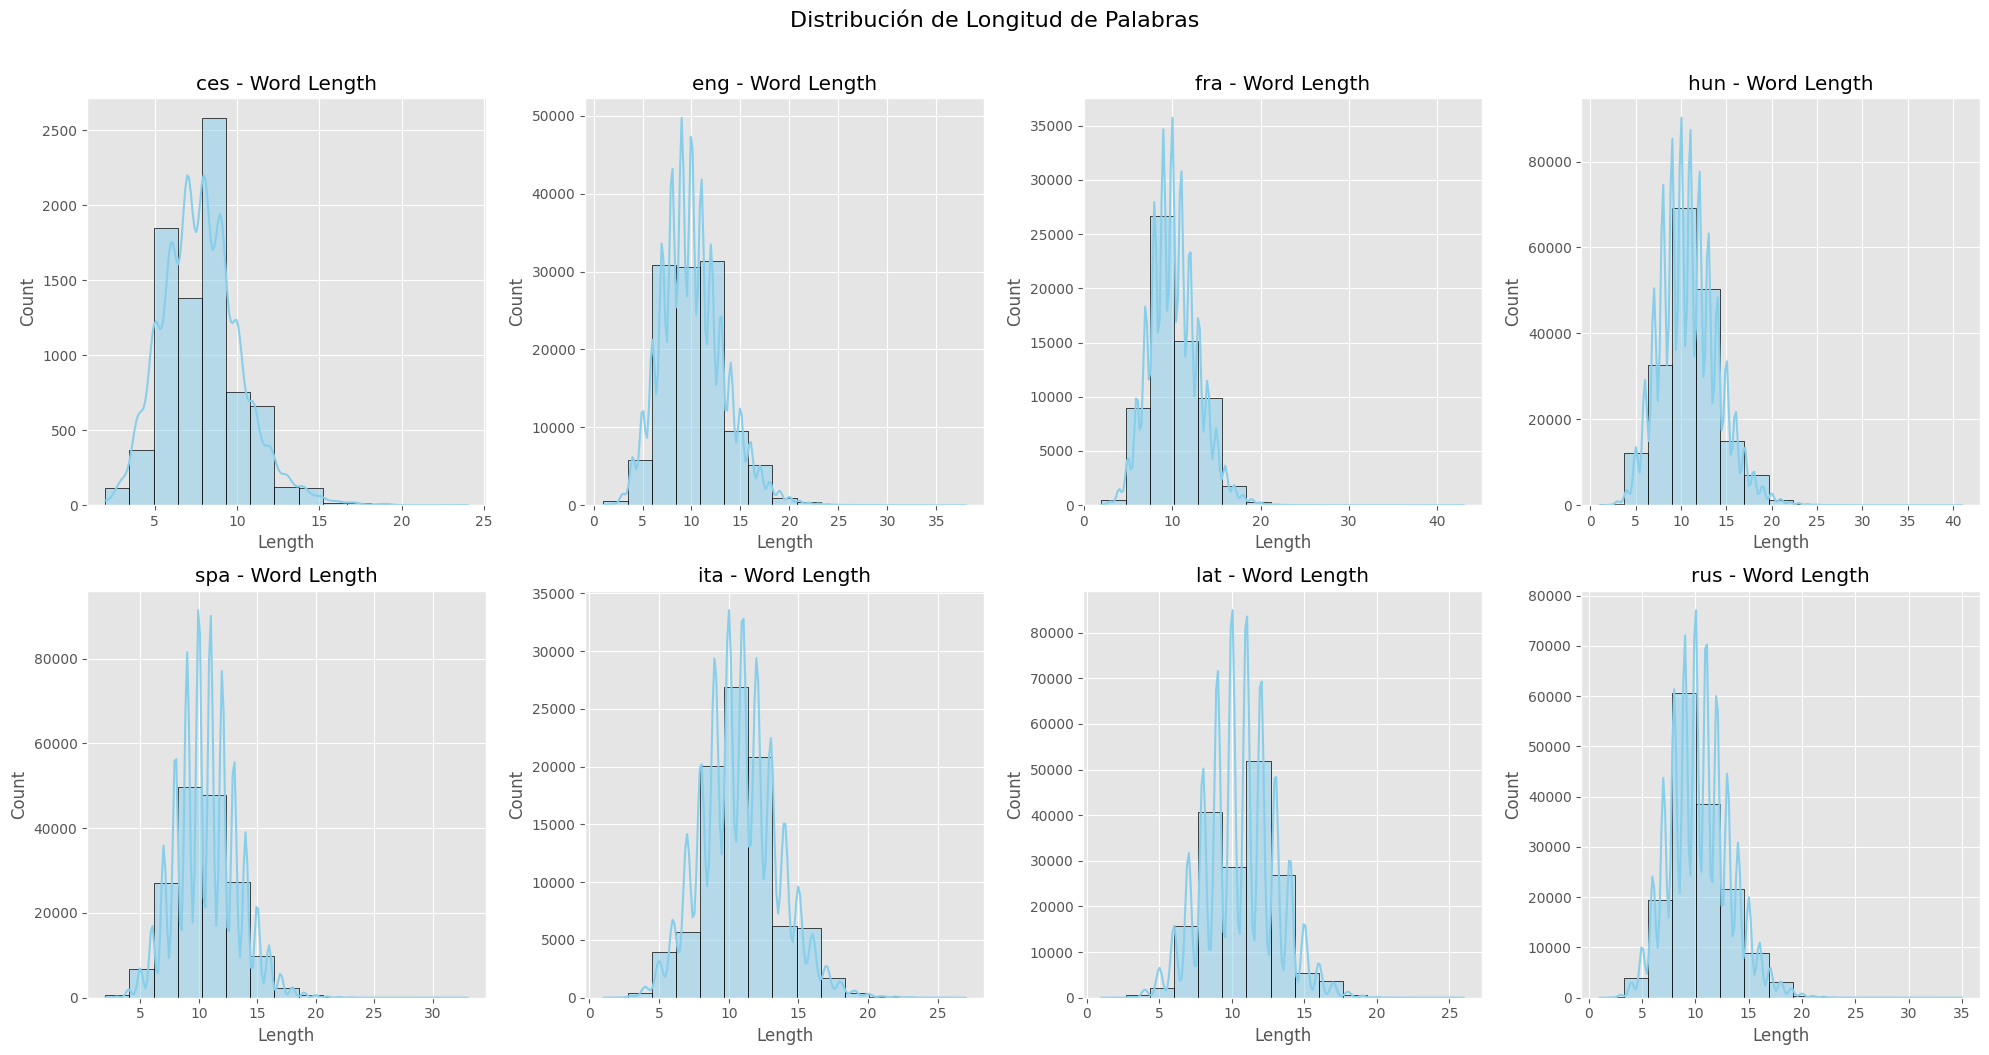

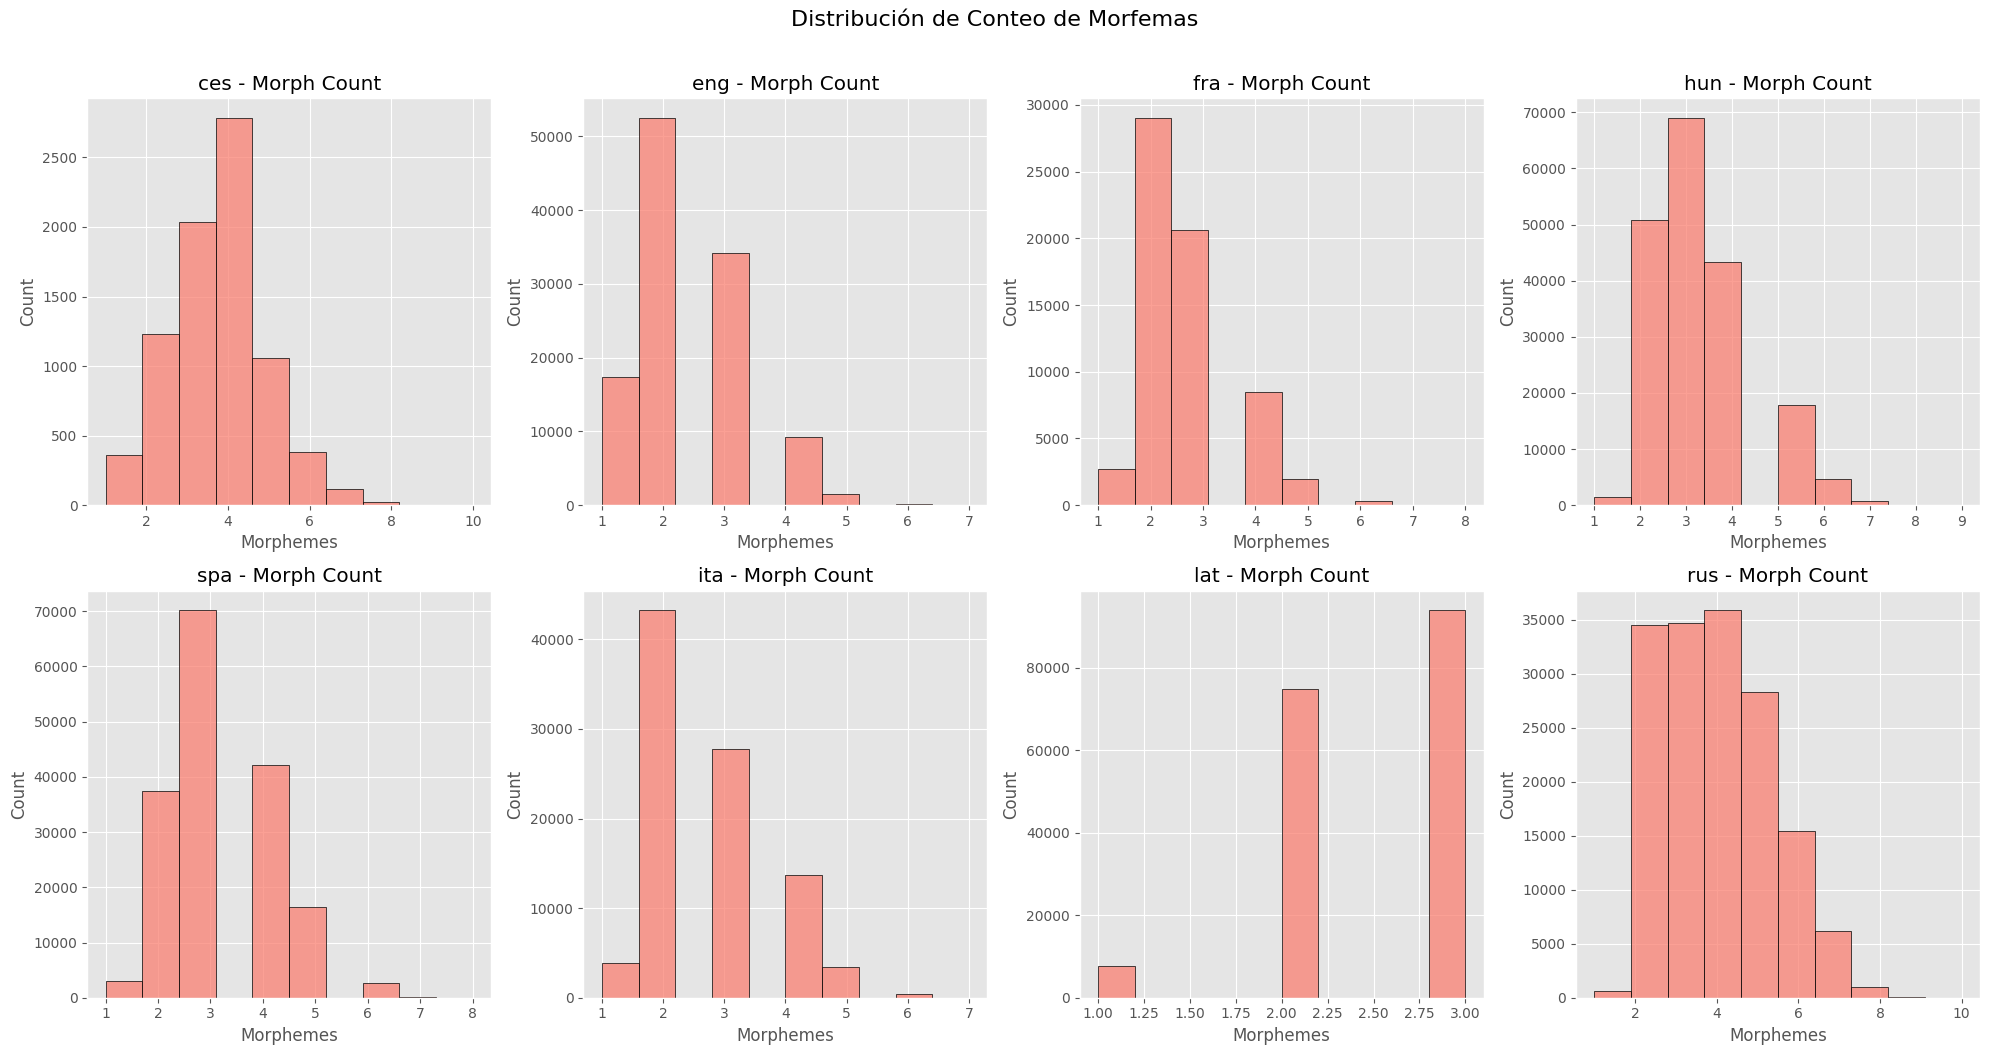

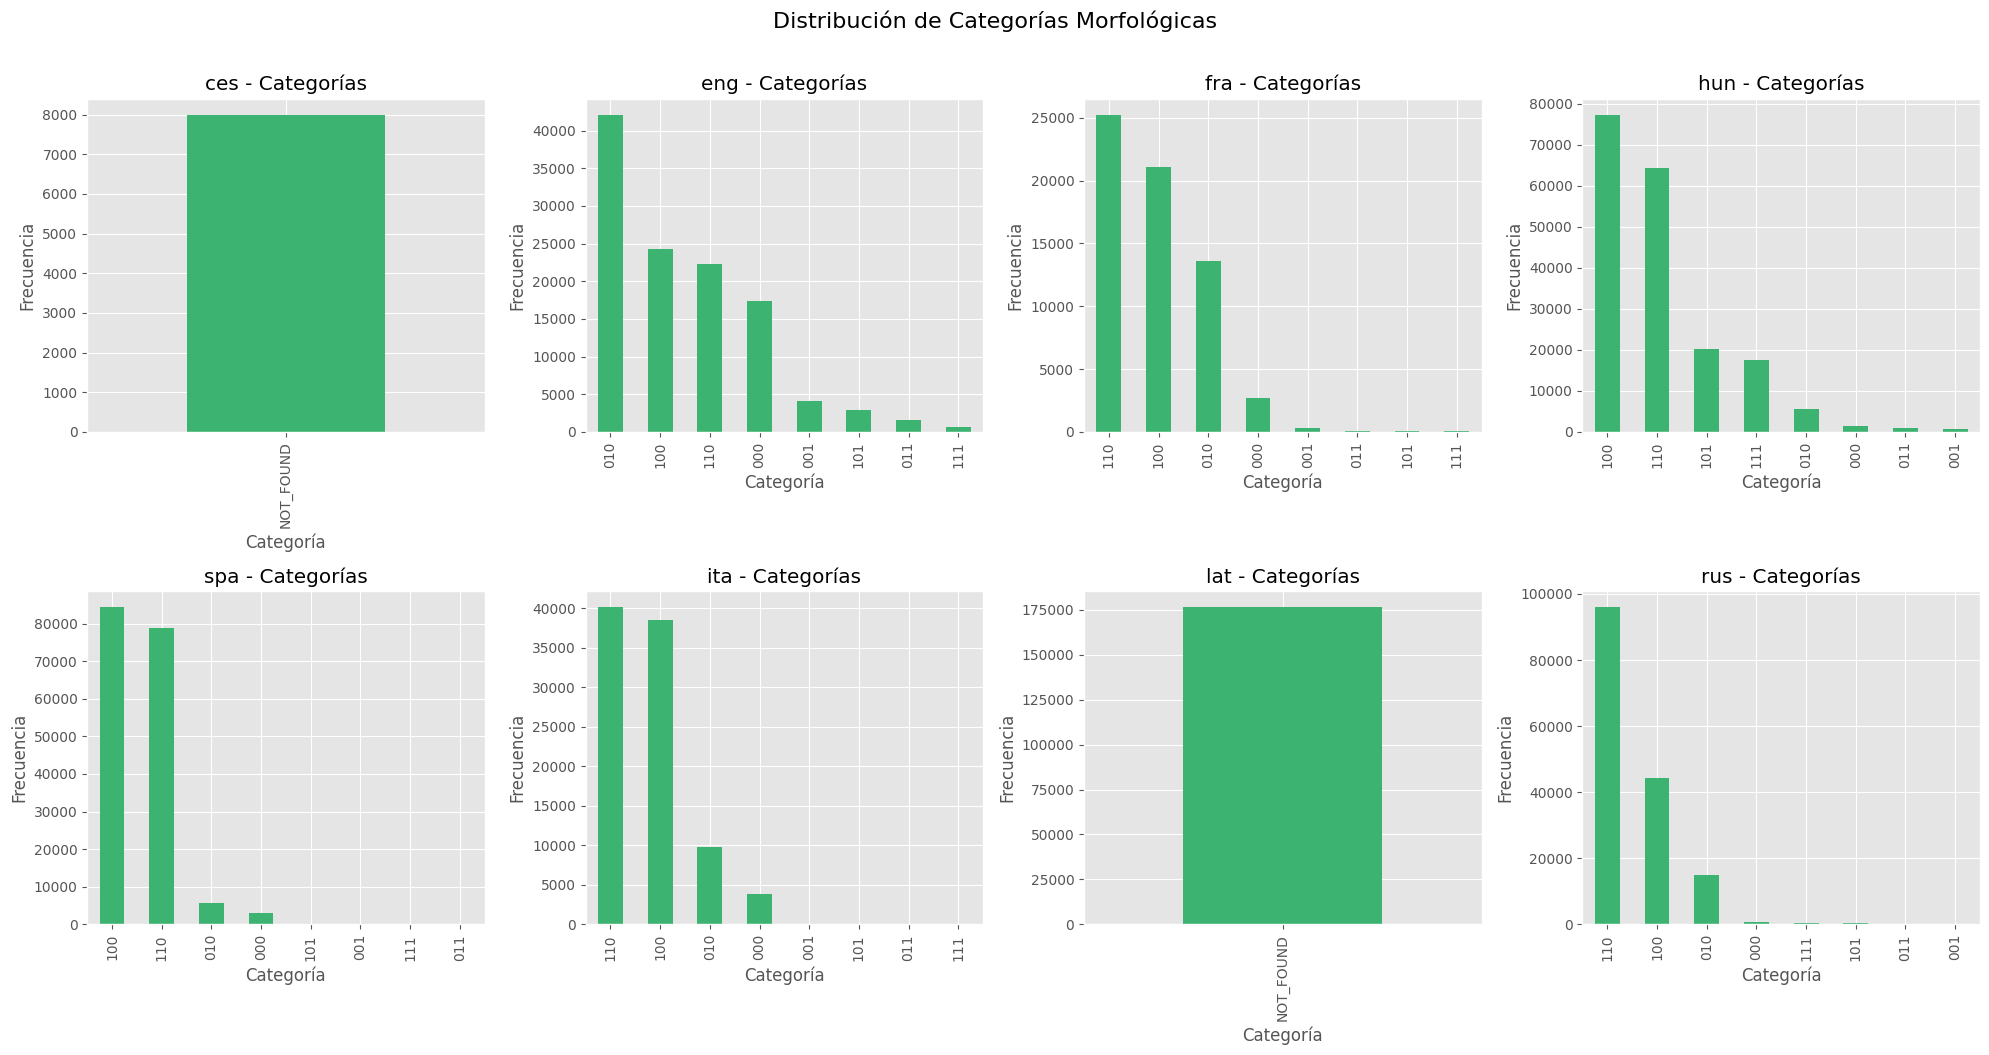

In [ ]:
plot_language_distributions(all_dfs)

In [ ]:
print_language_summary(all_dfs)

Resumen estadístico por lengua:

Lengua: ces
 - Total de palabras: 8000
 - Longitud promedio de palabra: 7.84
 - Cuenta promedio de morfemas: 3.59
 - Categoría más común: NOT_FOUND

Lengua: eng
 - Total de palabras: 115126
 - Longitud promedio de palabra: 10.11
 - Cuenta promedio de morfemas: 2.35
 - Categoría más común: 010

Lengua: fra
 - Total de palabras: 63173
 - Longitud promedio de palabra: 10.20
 - Cuenta promedio de morfemas: 2.67
 - Categoría más común: 110

Lengua: hun
 - Total de palabras: 188074
 - Longitud promedio de palabra: 10.86
 - Cuenta promedio de morfemas: 3.23
 - Categoría más común: 100

Lengua: spa
 - Total de palabras: 172173
 - Longitud promedio de palabra: 10.69
 - Cuenta promedio de morfemas: 3.24
 - Categoría más común: 100

Lengua: ita
 - Total de palabras: 92304
 - Longitud promedio de palabra: 10.80
 - Cuenta promedio de morfemas: 2.68
 - Categoría más común: 110

Lengua: lat
 - Total de palabras: 176467
 - Longitud promedio de palabra: 10.55
 - Cuenta 

**Longitud de palabras**: En casi todas las lenguas analizadas, las palabras tienen en promedio entre 10 y 11 letras. La única excepción notable es el checo, donde las palabras son más cortas (aprox. 7.8 letras).

Complejidad morfológica:

El inglés es la lengua más simple morfológicamente: tiene la menor cantidad de morfemas por palabra (2.35 en promedio), lo que sugiere que se basa más en el orden de palabras y palabras auxiliares que en modificaciones internas (afijos).

En cambio, ruso y húngaro presentan la mayor complejidad morfológica. Tienen un número alto de morfemas por palabra (hasta 3.85 en ruso), lo que indica una estructura rica en flexiones y aglutinaciones.

Lenguas romances (español, francés, italiano y latín):

Comparten características similares: longitud media de palabra (~10.5 letras) y entre 2.5 y 3.2 morfemas por palabra.

Estas lenguas muestran una tendencia clara al uso combinado de inflexión y derivación, lo que las hace estructuralmente más ricas que el inglés, pero más simples que lenguas como el ruso.

Etiquetado de categorías:

Algunas lenguas como latín y checo no tienen categorías morfológicas identificadas en el dataset (NOT_FOUND), lo que limita un poco el análisis cualitativo en esos casos.

En las demás lenguas, las categorías más comunes incluyen inflexión (100), derivación (010) o combinaciones como 110, lo cual tiene sentido ya que estas transformaciones afectan principalmente a sustantivos y verbos, que son las clases de palabras más frecuentes.